In [1]:
import numpy as np
import pandas as pd
from nilearn import image as nli
from nilearn import plotting as nl_plotting
from nilearn.maskers import NiftiMapsMasker
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

from math import ceil
from dtw import dtw
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from typing import List
from tqdm import tqdm

c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\nilearn\__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## 1 - Import data

In [2]:
from pathlib import Path
import glob
import seaborn as sns

In [3]:
root_folder = Path().resolve().parent

In [4]:
data_folder = root_folder / '__data'
# print(f"Data folder : {data_folder}")

In [5]:
ROIs_maps_filename = data_folder / f'subCSI1_ROIs_maps.nii.gz' # depend of the run ?

if not ROIs_maps_filename.exists():
    brainmask_files = sorted(glob.glob(str(data_folder / 'sub1ROIs' / 'subCSI1')+'*_brainmask*'))  # depend of the run ?
    sum_img = nli.load_img(brainmask_files[0])
    atlas_files = sorted(glob.glob(str(data_folder / 'sub1ROIs' / 'subCSI1')+'*_mask*')) # to sort ?
    print(f"There are {len(atlas_files)} ROIs")
    maps = nli.concat_imgs(atlas_files)



    print(f"Size of images : {maps.shape}")
    print(f"Labels values: {np.unique(maps.get_fdata())}")
    maps.to_filename(str(ROIs_maps_filename))

ROIs_labels = np.loadtxt(data_folder / 'ROIs_labels.txt', dtype=str)
print(ROIs_labels)

['LHEarlyVis' 'LHLOC' 'LHOPA' 'LHPPA' 'LHRSC' 'RHEarlyVis' 'RHLOC' 'RHOPA'
 'RHPPA' 'RHRSC']


In [6]:
# img_path = root_folder / 'Cloned/ds001499/derivatives/fmriprep/sub-CSI1/ses-01/func'

In [7]:
# confounds_filename = data_folder / 'sub1_ses01_run01_confounds.tsv'
# confounds_df = pd.read_csv(confounds_filename, sep='\t')
# print(confounds_df.columns)
# confounds_df.bfill(inplace=True)
# print(confounds_df.shape)

Index(['CSF', 'WhiteMatter', 'GlobalSignal', 'stdDVARS', 'non-stdDVARS',
       'vx-wisestdDVARS', 'FramewiseDisplacement', 'tCompCor00', 'tCompCor01',
       'tCompCor02', 'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00',
       'aCompCor01', 'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05',
       'Cosine00', 'Cosine01', 'Cosine02', 'Cosine03', 'Cosine04',
       'NonSteadyStateOutlier00', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ'],
      dtype='object')
(194, 31)


In [8]:
# img_files = [str(img_path / 'sub-CSI1_ses-01_task-5000scenes_run-0{}_bold_space-T1w_preproc.nii.gz').format(i) for i in range(1,7)]

# ims = [nli.load_img(img_filename) for img_filename in img_files]
# print("number of images : ", len(ims))
# print("dimension of each image : ", np.shape(ims[5]))

number of images :  6
dimension of each image :  (71, 89, 72, 194)


In [9]:
# time_series_filenames = [data_folder / 'sub1_ses01_run0{}_time_series.npy'.format(i) for i in range(6)]

# all_time_series = []

# for img_filename in img_files :
#     masker = NiftiMapsMasker(maps_img=ROIs_maps_filename,
#                             standardize='zscore_sample',
#                             standardize_confounds='zscore_sample',
#                             )
#     time_series = masker.fit_transform(img_filename, confounds=confounds_df)
#     all_time_series.append(time_series)
#     print(time_series.shape)

(194, 10)
(194, 10)
(194, 10)
(194, 10)
(194, 10)
(194, 10)


In [5]:
all_time_series = np.load(data_folder / 'allruns_TS.npy')[:3]
print(all_time_series.shape)

(3, 194, 10)


show the 10 1D-time series associated to the first image 

In [12]:
# color_brain_regions = sns.color_palette(n_colors=10)
# fig, ax = plt.subplots(10, 1, figsize=(10, 10))
# for i in range(10):
#     ax[i].plot(all_time_series[0][:, i], color=color_brain_regions[i], label=f'{ROIs_labels[i]}')
#     ax[i].legend(loc='upper right')
#     if i != 9:
#         ax[i].tick_params('x', labelbottom=False)

# ax[i].set_xlabel('Time')
# fig.tight_layout()
# plt.show()

# fig.savefig(figure_folder / 'plot_time_series.png')

## 2 - Compute connectivity

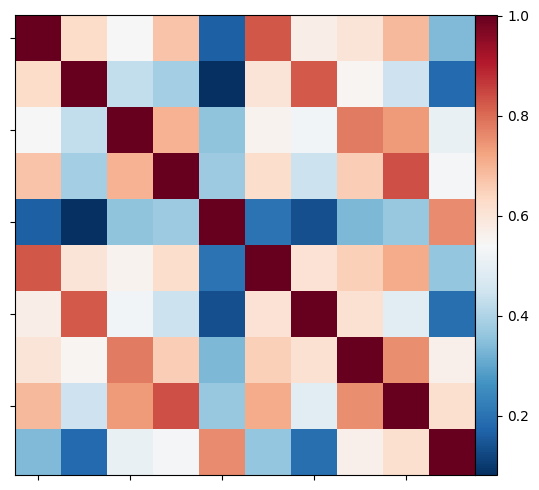

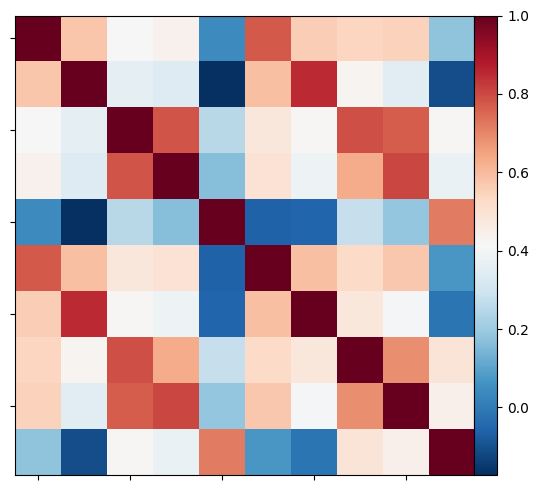

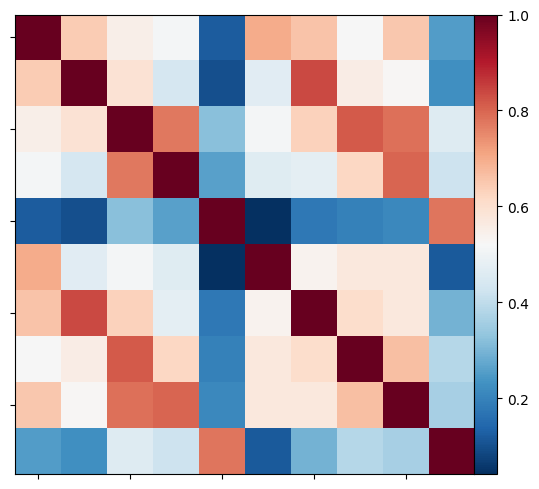

In [6]:
correlation_matrices = []
for time_series in all_time_series :
    correlation_measure = ConnectivityMeasure(
        kind="correlation",
        standardize="zscore_sample",
    )
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    correlation_matrices.append(correlation_matrix)
    nl_plotting.plot_matrix(correlation_matrix)
plt.show()

Compute brain coordinates of each region

In [12]:
coordinates = nl_plotting.find_probabilistic_atlas_cut_coords(ROIs_maps_filename)
print(coordinates.shape)

(10, 3)


Plot each of the 6 / 8 brain graphs

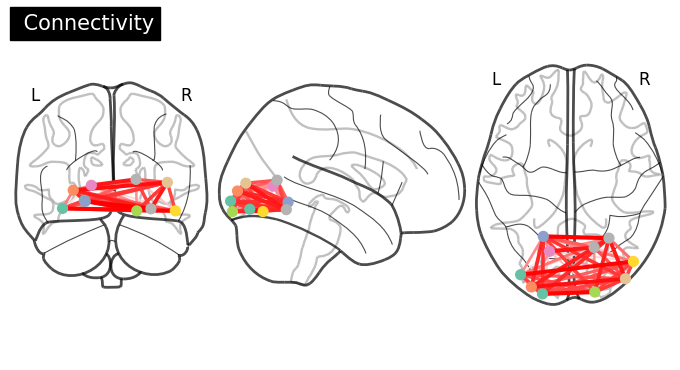

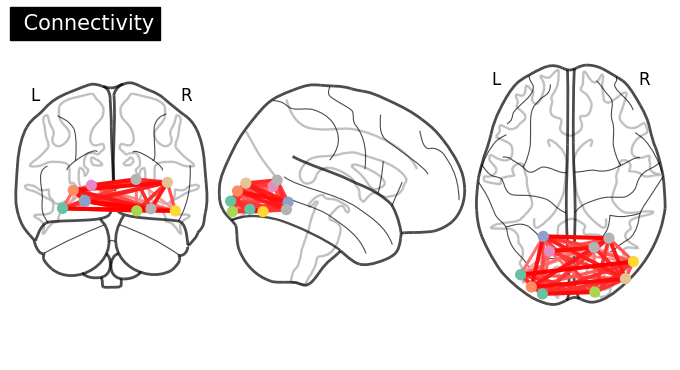

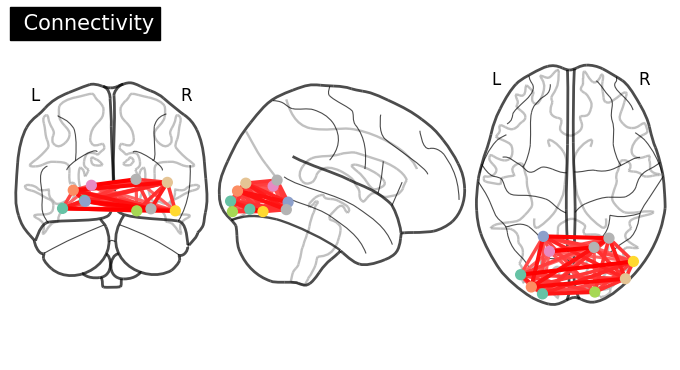

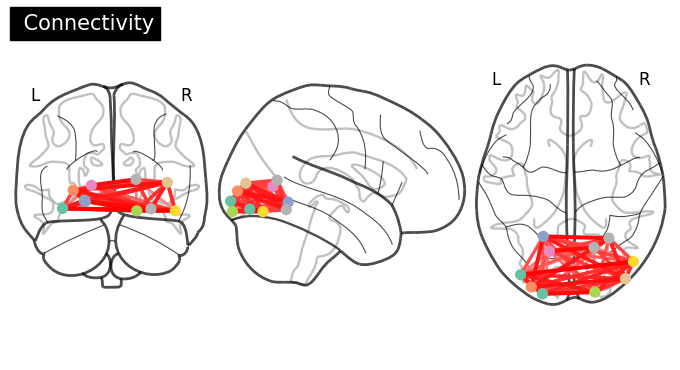

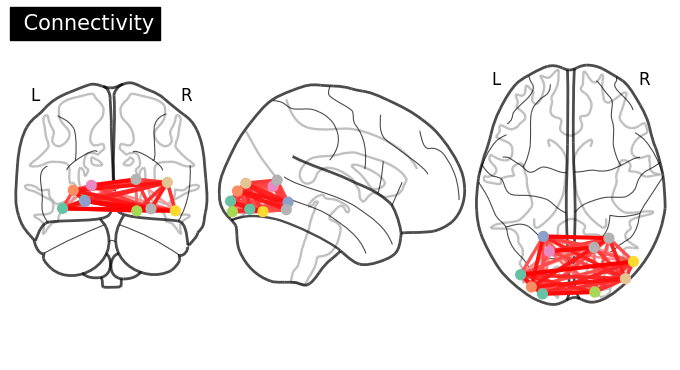

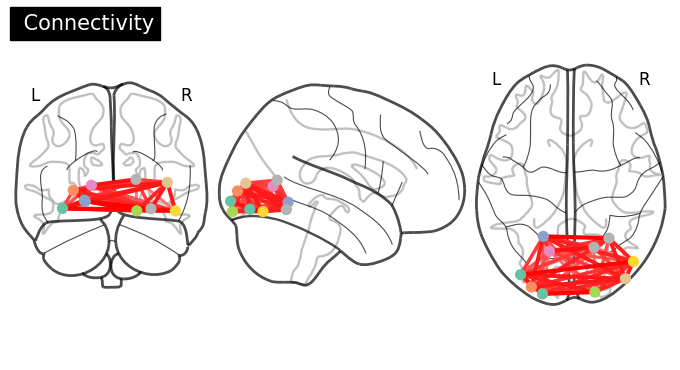

In [13]:
for correlation_matrix in correlation_matrices :
    nl_plotting.plot_connectome(correlation_matrix,
                             coordinates,
                            #  edge_threshold="100%",
                             title=' Connectivity')
plt.show()

## 3 - Define pyGSP objects

One graph for all the run : This common graph is obtained by averaging the connectivity matrices.

In [7]:
from pygsp import graphs

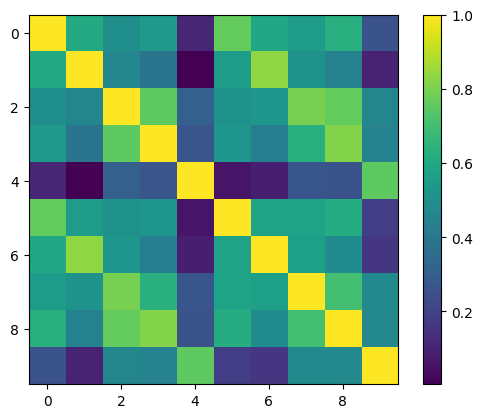

In [8]:
average_correlation_matrix = np.mean(correlation_matrices, axis=0)

plt.imshow(average_correlation_matrix)
plt.colorbar()
plt.show()

In [9]:
np.fill_diagonal(average_correlation_matrix, 0)
G = graphs.Graph(average_correlation_matrix)
G.compute_fourier_basis()

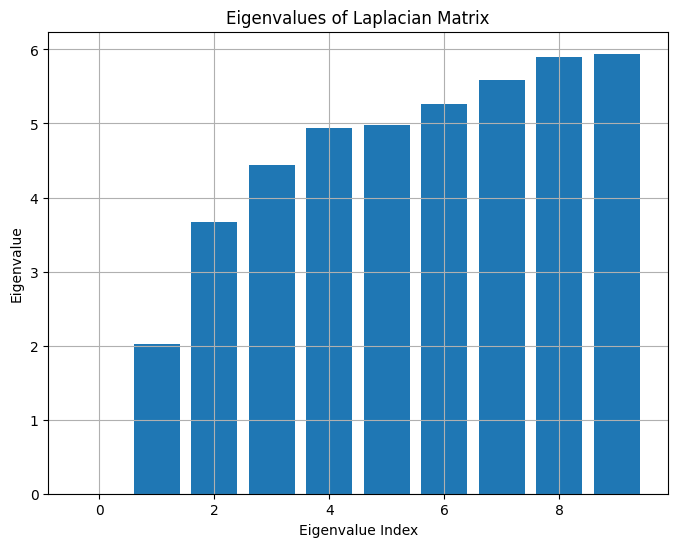

In [10]:
# Plotting the bar diagram of sorted eigenvalues
plt.figure(figsize=(8, 6))
plt.bar(np.arange(G.e.shape[0]), G.e)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Laplacian Matrix')
plt.grid(True)
plt.show()

## 4 - Compute Fourier Transform of a graph signal

In [20]:
# Xs = []
# for time_series in all_time_series :
#     X = time_series.T
#     Xs.append(X)

(10, 194)


In [28]:
def plot_stems (X_tild) :
    plt.figure(figsize=(8, 6))
    markerline, stemlines, baseline = plt.stem(np.arange(G.e.shape[0]), np.square(X_tild), linefmt='-', markerfmt='o', basefmt=' ')
    plt.setp(stemlines, linestyle='-')  # Change stem line properties
    plt.setp(markerline, markersize=8)  # Change marker properties
    plt.setp(baseline, visible=False)  # Hide the baseline
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Norm of Fourier Coefficients')
    plt.title('Norm of Fourier Coefficients Associated with Eigenvalues')
    plt.grid(True)

In [25]:
X0 = Xs[0]
X0_tilds = G.U.T@X0[:]

In [26]:
X0_tilds.shape

(10, 194)

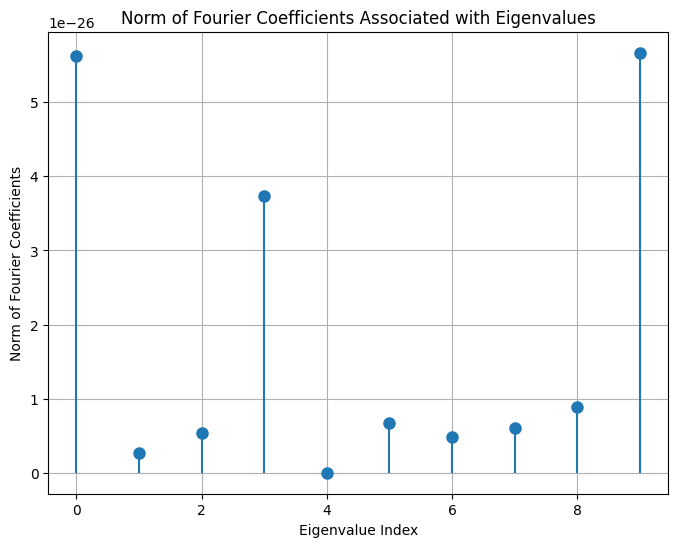

In [29]:
plot_stems(X0_tilds[:,0])

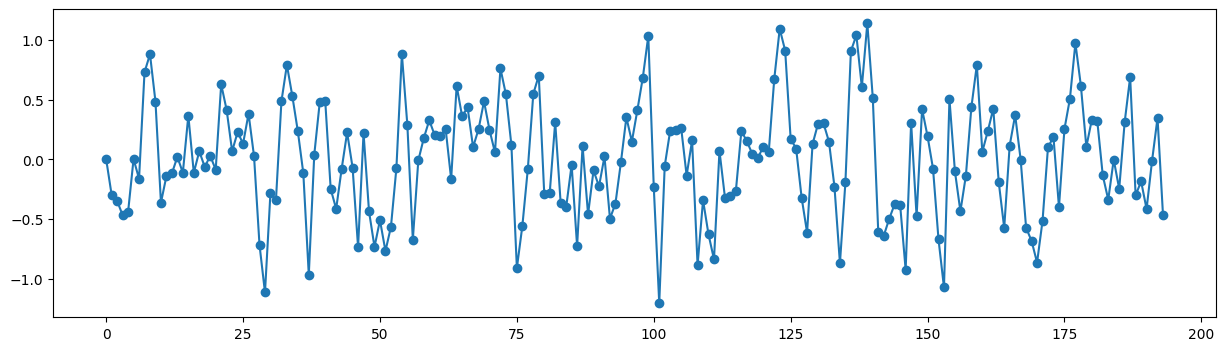

In [30]:
plt.figure(figsize=(15, 4))
plt.scatter(np.arange(X0_tilds.shape[-1]),X0_tilds[5])
plt.plot(X0_tilds[5])

In [12]:
events_path = sorted(glob.glob(str(data_folder / 'sub1') + '*events.tsv'))[:3]
print(len(events_path))
print(events_path)

3
['C:\\Users\\INES\\Documents\\3A_MVA\\ML_for_TS\\TimeSeries-GraphSignalProcessing\\__data\\sub1_ses01_run01_events.tsv', 'C:\\Users\\INES\\Documents\\3A_MVA\\ML_for_TS\\TimeSeries-GraphSignalProcessing\\__data\\sub1_ses01_run02_events.tsv', 'C:\\Users\\INES\\Documents\\3A_MVA\\ML_for_TS\\TimeSeries-GraphSignalProcessing\\__data\\sub1_ses01_run03_events.tsv']


In [13]:
all_events = [pd.read_table(event, sep='\t') for event in events_path]
print(len(all_events))

3


In [87]:
all_events[2]

,onset,duration,Subj,Sess,Run,Trial,ImgName,ImgType,StimOn(s),StimOff(s),Response,RT,stim_file
0,6.0397,0.9678,1,1,3,1,COCO_train2014_000000090569.jpg,coco,6.0397,7.0074,1,3.0228,COCO_train2014_000000090569.jpg
1,16.0151,0.9841,1,1,3,2,COCO_train2014_000000425135.jpg,coco,16.0151,16.9992,3,2.0076,COCO_train2014_000000425135.jpg
2,26.0081,0.9994,1,1,3,3,pasture9.jpg,scenes,26.0081,27.0075,1,2.0177,pasture9.jpg
3,35.9984,1.0008,1,1,3,4,n01443537_2819.JPEG,imagenet,35.9984,36.9992,2,3.5698,n01443537_2819.JPEG
4,46.0080,0.9996,1,1,3,5,tailor6.jpg,rep_scenes,46.0080,47.0076,2,3.5856,tailor6.jpg
5,55.9985,1.0008,1,1,3,6,COCO_train2014_000000015183.jpg,coco,55.9985,56.9993,1,1.5939,COCO_train2014_000000015183.jpg
6,66.0076,1.0001,1,1,3,7,n04179913_10794.JPEG,imagenet,66.0076,67.0077,2,4.8337,n04179913_10794.JPEG
7,75.9986,1.0008,1,1,3,8,n03791053_3596.JPEG,imagenet,75.9986,76.9994,1,4.5295,n03791053_3596.JPEG
8,86.0072,1.0006,1,1,3,9,n02808304_3656.JPEG,imagenet,86.0072,87.0078,2,2.1615,n02808304_3656.JPEG
9,95.9987,1.0008,1,1,3,10,yogastudio2.jpg,scenes,95.9987,96.9995,3,2.0253,yogastudio2.jpg


In [56]:
all_onsets = [events.onset.values/388*194 for events in all_events]
print(all_onsets)

[array([  3.0159 ,   8.0036 ,  12.9994 ,  18.00395,  22.99945,  28.0041 ,
        32.9995 ,  38.0037 ,  42.9996 ,  48.0038 ,  52.99965,  58.00385,
        62.99975,  68.0039 ,  72.99975,  78.00395,  82.99985,  88.00405,
        92.9999 ,  98.00425, 102.99995, 108.00415, 113.00005, 118.00425,
       123.0001 , 128.0043 , 133.00015, 138.00435, 143.0002 , 148.0044 ,
       153.00025, 158.00445, 163.00035, 168.00455, 173.0004 , 178.0046 ,
       183.00045]), array([  3.0154 ,   8.0031 ,  12.9989 ,  18.0031 ,  22.99895,  28.004  ,
        32.999  ,  38.0039 ,  42.99905,  48.0038 ,  52.9991 ,  58.0041 ,
        62.9992 ,  68.00395,  72.99925,  78.0041 ,  82.99925,  88.00405,
        92.99935,  98.0035 , 102.9994 , 108.00355, 112.99945, 118.00395,
       122.9995 , 128.00375, 132.99955, 138.00395, 142.9996 , 148.004  ,
       152.99965, 158.00395, 162.9997 , 168.0039 , 172.99975, 178.00395,
       182.9998 ]), array([  3.01985,   8.00755,  13.00405,  17.9992 ,  23.004  ,  27.99925,
        33

[None]

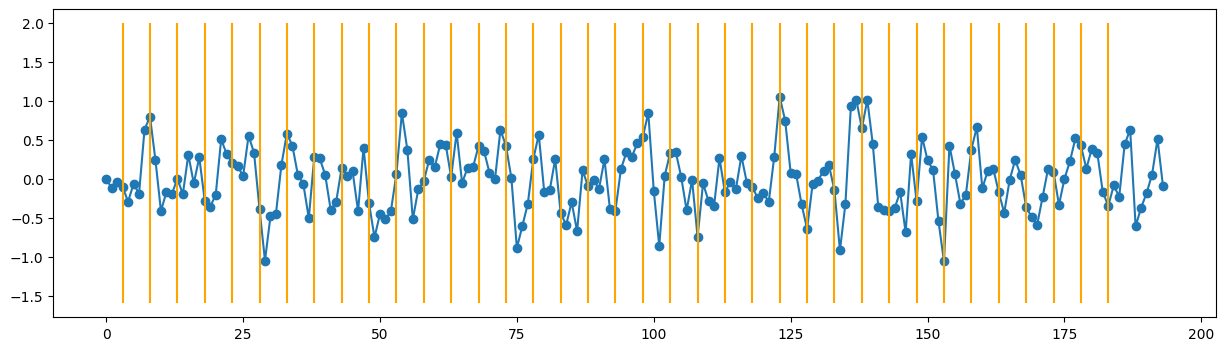

In [28]:
plt.figure(figsize=(15, 4))
plt.scatter(np.arange(X0_tilds.shape[-1]),X0_tilds[5])
plt.plot(X0_tilds[5])

markerline, stemlines, baseline = plt.stem(all_onsets[0], 2*np.ones(37), linefmt='orange', markerfmt=' ', basefmt=' ', bottom=-1.6)
plt.setp(stemlines, linestyle='-')  # Change stem line properties
plt.setp(markerline, markersize=8)

## 5 - Load labels

In [59]:
# y_builders = [events[['onset','Response']].values for events in all_events]
# print(y_builders[0].shape)

3
(37, 2)


In [60]:
def find_label(i,y_builder):
    target_time = i / 194 * 388
    j = 0
    while j<37 and target_time >= y_builder[j,0]:
        j +=1
    return y_builder[j-1,1]

In [61]:
def find_first_i(first_time):
    i = 0
    while i < first_time * 194 / 388:
        i += 1
    return i

In [93]:
194/388

0.5

In [63]:
# ys = []

# first_is = []
# for y_builder in y_builders :
#     first_i = find_first_i(y_builder[0,0])
#     first_is.append(first_i)
#     l = 187 - first_i+1
#     y = np.zeros(l)
#     for i in range(first_i-1,187) :
#         y[i-first_i+1] = find_label(i,y_builder)
#     ys.append(y)

In [14]:
# define labels (nb_runs*nb_stimuli,) and data list of lenght nb_runs*nb_stimuli of array of shape (nb_regions, lengh_sub_TS)
# sub time series can have different length

xs, ys = [], []

for run, event in enumerate(all_events) :
    for j, img in enumerate(event.ImgName):

        on_img_indx = ceil(event.onset[j] * 194 / 388)
        if j >= len(event)-1:
            out_img_indx = 187 #ceil(370 * 194 / 388) # the stimuli stops after 370 seconds
        else :
            out_img_indx = int(event.onset[j+1] * 194 / 388)

        ys.append(event.Response[j])
        xs.append(all_time_series[run, on_img_indx:(out_img_indx+1), :].T)

print(len(ys))
print(len(xs))
# for i, x in enumerate(xs) :
#     print(x.shape)

111
111


### K-NN with DTW

In [15]:
def region_dtw_distance(graph_signal1: np.ndarray, graph_signal_2: np.ndarray,
                        ) -> float:
    nb_r = graph_signal1.shape[0]
    dist = 0
    for r in range(nb_r):
        alignment_dtw = dtw(graph_signal1[r, :], graph_signal_2[r, :])
        alignement_value = alignment_dtw.distance
        dist += alignement_value
        
    return dist / nb_r

def compute_distance_matrix(graph_signals: List[np.ndarray], references : List[np.ndarray] = None
                            )->np.ndarray:
    if references is None :
        dist_matrix = np.zeros((len(graph_signals), len(graph_signals)))
        for i, signal1 in enumerate(graph_signals):
            dist_matrix[i, i] = 0
            for j, signal2 in enumerate(graph_signals[i+1:]):
                dist_matrix[i, i+j+1] = dist_matrix[i+j+1, i] = region_dtw_distance(signal1, signal2)

    else :
        dist_matrix = np.empty((len(graph_signals), len(references)))
        for i, signal in enumerate(graph_signals):
            for j, ref in enumerate(references):
                dist_matrix[i, j] = region_dtw_distance(signal, ref)
                # print('test dist', dist_matrix[i, j])

    return dist_matrix

def train_knn(distance_matrix: np.ndarray,
              y: List[int], 
              n_neighbors: int) -> KNeighborsClassifier:
    
    return KNeighborsClassifier(n_neighbors=n_neighbors, metric="precomputed").fit(distance_matrix, y)

In [33]:
def compute_forward(classifier: KNeighborsClassifier, X_basis: List[np.ndarray], X: List[np.ndarray]):
    distance_matrix = compute_distance_matrix(X, X_basis)
    return classifier.predict(distance_matrix)

def compute_score(y_pred: np.ndarray, y_true: np.ndarray):
    return balanced_accuracy_score(y_true, y_pred)

def train(X: List[np.ndarray],
          y: List[int],
          n_neighbors: List[int],
          n_splits=5) -> np.ndarray:
    
    scores = np.empty((n_splits, len(n_neighbors)))
    kf = KFold(n_splits, shuffle=True)

    for i, (train_index, test_index) in tqdm(enumerate(kf.split(X, y)), total=n_splits, desc='Cross validation'):
        X_train_fold, y_train_fold = [X[i] for i in train_index], np.array([y[i] for i in train_index])
        X_test_fold, y_test_fold = [X[i] for i in test_index], np.array([y[i] for i in test_index])
        # print('train', len(train_index), 'test', len(test_index))
        
        distance_matrix = compute_distance_matrix(X_train_fold)
        for j, k in enumerate(n_neighbors):
            classifier = train_knn(distance_matrix, y_train_fold, k)
            y_pred_fold = compute_forward(classifier, X_train_fold, X_test_fold)
            scores[i,j] = compute_score(y_test_fold, y_pred_fold)
    return scores

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
nb_neighbors = [2, 3, 4, 5, 10, 20]
scores = train(xs, ys, nb_neighbors, n_splits=5)

Cross validation: 100%|██████████| 5/5 [05:40<00:00, 68.06s/it]


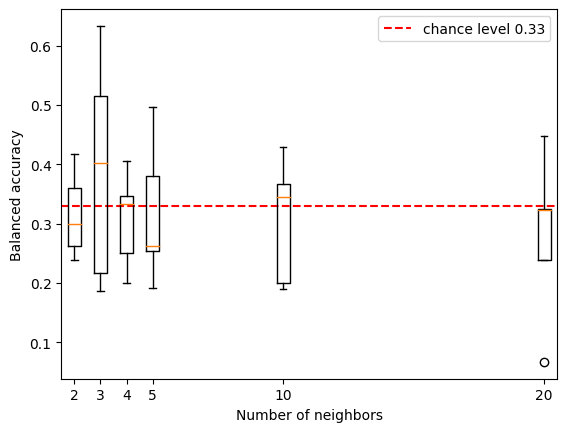

In [36]:
figure_folder = root_folder / 'Report' / 'img'
fig = plt.figure()
plt.axhline(y=0.33, color='r', xmin=0, xmax=15, linestyle='--', label='chance level 0.33')
plt.boxplot(scores, positions=nb_neighbors)
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Balanced accuracy')
plt.show()

fig.savefig(figure_folder / '5-fold_knn_scores.png')

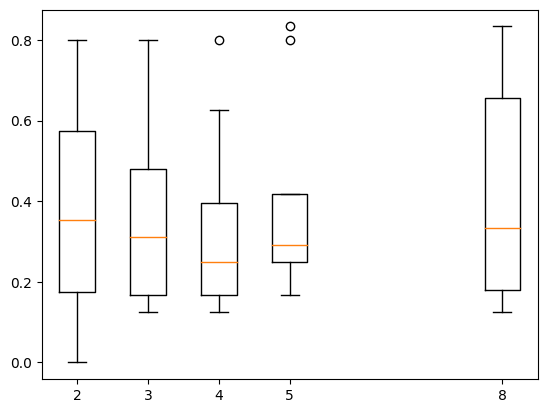

In [277]:
plt.boxplot(scores, positions=nb_neighbors)
plt.show()

Cross validation:   0%|          | 0/20 [00:00<?, ?it/s]

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INE

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Cross valida

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INE

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INE

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INE

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INE

train 35 test 2


Cross validation:  35%|███▌      | 7/20 [00:23<00:48,  3.76s/it]

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Cross valida

train 35 test 2


Cross validation:  45%|████▌     | 9/20 [00:30<00:37,  3.41s/it]

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INE

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Cross validation:  55%|█████▌    | 11/20 [00:36<00:29,  3.26s/it]

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INE

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INE

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Cross validation:  70%|███████   | 14/20 [00:46<00:20,  3.50s/it]

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INE

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INE

train 35 test 2


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Cross validation:  85%|████████▌ | 17/20 [00:56<00:09,  3.24s/it]

train 36 test 1


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Cross validation:  90%|█████████ | 18/20 [00:59<00:06,  3.15s/it]

train 36 test 1


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Cross validation:  95%|█████████▌| 19/20 [01:01<00:02,  2.99s/it]

train 36 test 1


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Cross validation: 100%|██████████| 20/20 [01:04<00:00,  3.23s/it]


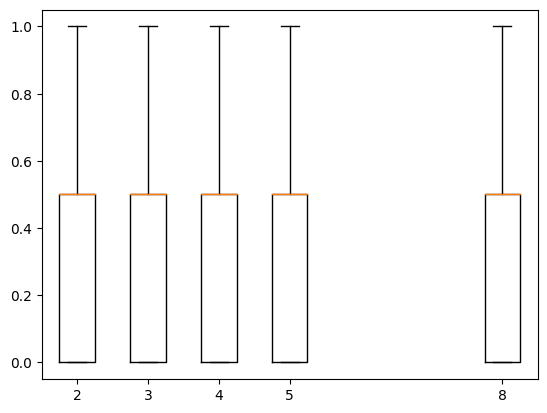

In [24]:
nb_neighbors = [2, 3, 4, 5, 8]
scores = train(xs[:37], ys[:37], nb_neighbors, n_splits=20)
plt.boxplot(scores, positions=nb_neighbors)
plt.show()

## 6 - Sklearn on raw activations (pas de Fourier)

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score,accuracy_score
from sklearn.model_selection import train_test_split

In [36]:
combined_raw_X = np.hstack(adjusted_raw_Xs).T
combined_y = np.hstack(ys)

In [37]:
combined_raw_X.shape

(1104, 10)

In [38]:
raw_X_train, raw_X_test, raw_y_train, raw_y_test = train_test_split(combined_raw_X, combined_y, test_size=0.2, random_state=42)

In [39]:
raw_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

In [40]:
raw_clf.fit(raw_X_train, raw_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [41]:
raw_y_pred = raw_clf.predict(raw_X_test)

In [42]:
balanced_accuracy_score(raw_y_test,raw_y_pred)

0.33741913517194416

## 7 - Sklearn on processed activations (normes de coeffs de Fourier en input)

In [43]:
all_X_tilds = [G.U.T@X for X in Xs]

In [44]:
Xs_pro = []
for X_tilds,first_i in zip(all_X_tilds,first_is) :
    X_pro = np.square(X_tilds)[:,first_i-1:187]
    Xs_pro.append(X_pro)

In [45]:
combined_X_pro = np.hstack(Xs_pro).T

In [46]:
pro_X_train, pro_X_test, pro_y_train, pro_y_test = train_test_split(combined_X_pro, combined_y, test_size=0.2, random_state=42)

In [47]:
pro_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 10), random_state=1)

In [50]:
pro_clf.fit(pro_X_train, pro_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 10), random_state=1,
              solver='lbfgs')

In [51]:
pro_y_pred = pro_clf.predict(pro_X_test)

In [52]:
balanced_accuracy_score(pro_y_test,pro_y_pred)

0.28864487572352737

## 8 - Idem with another model

In [53]:
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC

In [54]:
HGBC_model = HGBC()

In [55]:
HGBC_model.fit(pro_X_train,pro_y_train)

HistGradientBoostingClassifier()

In [56]:
y_pred_train_pro_HGCB = HGBC_model.predict(pro_X_train)

In [57]:
balanced_accuracy_score(pro_y_train,y_pred_train_pro_HGCB)

1.0

In [58]:
y_pred_test_pro_HGCB = HGBC_model.predict(pro_X_test)

In [59]:
balanced_accuracy_score(pro_y_test,y_pred_test_pro_HGCB)

0.3235869935308137

## 9 - Dictionnary learning

In [60]:
from alphacsc import learn_d_z

In [61]:
def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))

In [62]:
signal = X0_tilds[5]

In [63]:
# Parameters to change
n_atoms = 15  # K
atom_length = 4  # L (2000 pour 1 seconde)
penalty = 1  # lambda

In [64]:
%%time
# learning a dictionary and codes
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=signal[None,:],
    n_atoms=n_atoms,
    n_times_atom=atom_length,
    reg=penalty,
    n_iter=30,
    n_jobs=4,
    verbose=1)

V_0/30 .............................
CPU times: total: 46.9 ms
Wall time: 3.31 s


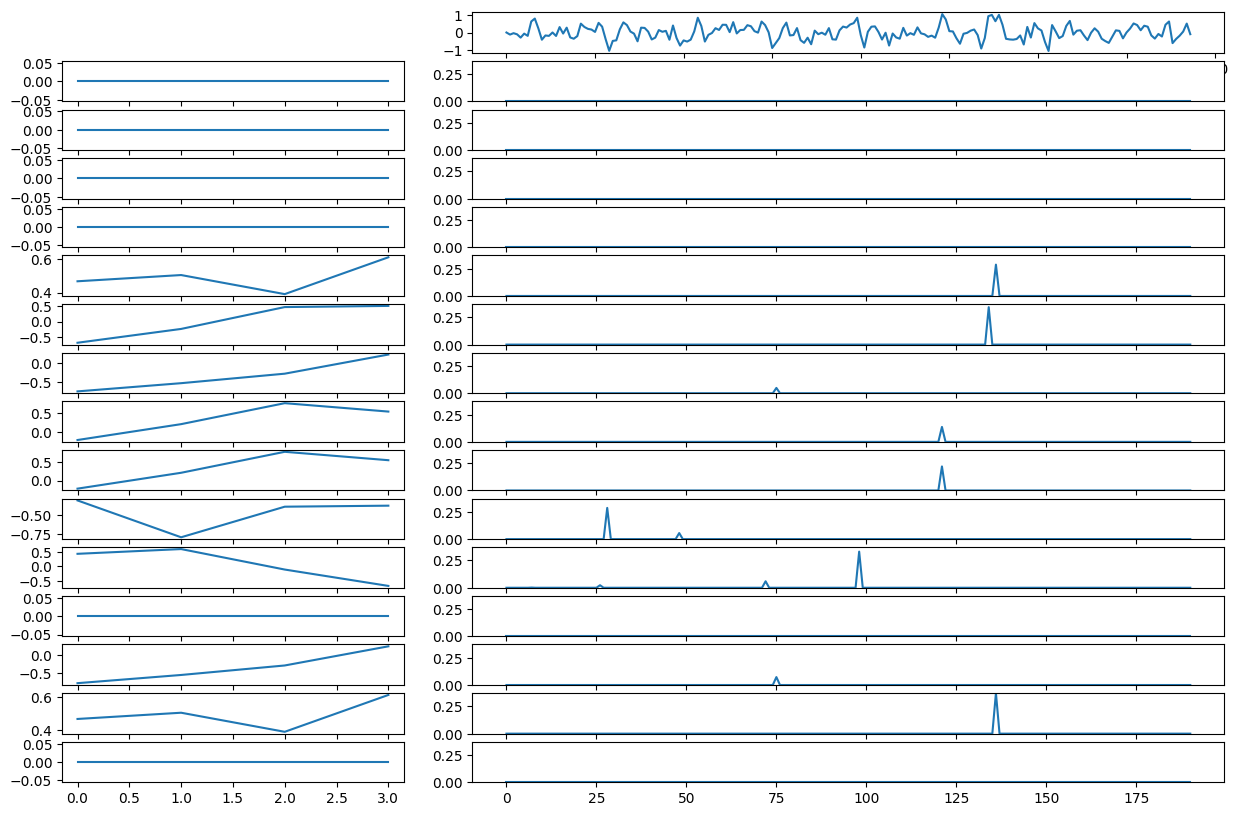

In [65]:
plot_CDL(signal, z_hat.T.squeeze(), d_hat.T.squeeze())